In [50]:
from typing import Any
from typing import Dict
from typing import List
from typing import Optional
from typing import Tuple

import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers


import os
import math

from sklearn.model_selection import train_test_split

def masked_mean_sequare_error_sw(y_true, y_pred):
    delta_y = y_pred - y_true
    delta_y = tf.where(tf.math.is_nan(delta_y), tf.zeros_like(delta_y), delta_y)
    
    squared_difference = tf.square(delta_y)
    
    return tf.reduce_mean(squared_difference)


class DataGenerator(tf.keras.utils.Sequence):
    def __init__(
        self,
        data: Optional[np.ndarray] = None,
        top_model = False,
        regression_target = None,
        batch_size: int = 32,
        n_steps_per_epoch: int = 100,
        shuffle: bool = True
    ):

        self.data = data
        self.batch_size = batch_size
        self.n_steps_per_epoch = n_steps_per_epoch
        self.shuffle = shuffle
        self.top_model = top_model
        
        if self.shuffle:
            self.step_batch_idx = np.random.choice(len(self.data), size=(self.n_steps_per_epoch, self.batch_size))
        else:
            self.step_batch_idx = np.arange(len(self.data)).reshape((1, -1))
        
        if self.top_model:
            self.regression_target = regression_target
            
            
    def __len__(self):
        return self.n_steps_per_epoch
        
    def __getitem__(self, i_batch):
        X, y = self.__data_generation(i_batch)
        return X['input_data'], y
        
    def on_epoch_end(self):
        if self.shuffle:

            self.step_batch_idx = np.random.choice(len(self.data), size=(self.n_steps_per_epoch, self.batch_size))
        else:
            self.step_batch_idx = np.arange(len(self.data)).reshape((1, -1))
        
    def __data_generation(self, i_batch):
        batch_idx = self.step_batch_idx[i_batch]
        X = np.zeros((self.batch_size, self.data.shape[1]), dtype=np.float32)
        regression_values = []
        y_dict = {}
        for i_data, idx in enumerate(batch_idx):
            if self.top_model:
                regression_values.append(self.regression_target[idx])
            
            X[i_data, :] = self.data[idx]
            
        if self.top_model:
            y_dict['Regression'] = np.asarray(regression_values)
        y_dict['Autoencoder'] = X.copy()
        
        return (dict(input_data=X), y_dict)

class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape = (batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [51]:
class VariationalAutoencoderWithTop(tf.keras.Model):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 top_model,
                 type_of_vae,
                 weights_dict,
                 **kwargs):
        super(VariationalAutoencoderWithTop,self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.weights_dict = weights_dict
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name = "reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name = "kl_loss")
        self.regression_loss_tracker = keras.metrics.Mean(name = "regression_loss")
        self.top_model = top_model
        self.type_of_vae = type_of_vae
        
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            self.regression_loss_tracker
        ]
    
    @staticmethod
    def compute_mmd(x, y):
        """
        Maximum Mean Discrepancy loss
        reference: https://ermongroup.github.io/blog/a-tutorial-on-mmd-variational-autoencoders/
        """

        def compute_kernel(x, y):
            x_size = tf.shape(x)[0]
            y_size = tf.shape(y)[0]
            dim = tf.shape(x)[1]
            tiled_x = tf.tile(tf.reshape(x, tf.stack([x_size, 1, dim])), tf.stack([1, y_size, 1]))
            tiled_y = tf.tile(tf.reshape(y, tf.stack([1, y_size, dim])), tf.stack([x_size, 1, 1]))
            return tf.exp(-tf.reduce_mean(tf.square(tiled_x - tiled_y), axis=2) / tf.cast(dim, tf.float32))

        x_kernel = compute_kernel(x, x)
        y_kernel = compute_kernel(y, y)
        xy_kernel = compute_kernel(x, y)
        return tf.reduce_mean(x_kernel) + tf.reduce_mean(y_kernel) - 2 * tf.reduce_mean(xy_kernel)
    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            X, y = data
            encoder_output = self.encoder(X)
            z = encoder_output['z_kld']
            if self.top_model:
                z_reg_model = encoder_output['z_reg_model']
            z_kld = encoder_output['z_kld']
            recon = self.decoder(z)
            
            reconstruction_loss = masked_mean_sequare_error_sw(y['Autoencoder'], recon)
            if self.top_model:
                y_true = tf.reshape(y['Regression'], (len(y['Regression']),1))
                y_pred = tf.reshape(z_reg_model, (len(y['Regression']),1))
                
                regression_loss = masked_mean_sequare_error_sw(y_true, y_pred)
            else:
                regression_loss = 0
            
            if self.type_of_vae =="ELBO":
                z_mean = encoder_output['z_mean']
                z_log_var = encoder_output['z_log_var']
                kl_loss = tf.reduce_mean(tf.reduce_sum(-0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)), axis=1))
                

            else:
                
                gaussian_sample = tf.random.normal(shape = (tf.shape(z_kld)[0], tf.shape(z_kld)[1]), mean = 0, stddev = 1)
                kl_loss = self.compute_mmd(gaussian_sample, z_kld)

            total_loss = self.weights_dict['kl_loss']*kl_loss + self.weights_dict['recon_loss']*reconstruction_loss + self.weights_dict['regression_loss']*regression_loss

            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.regression_loss_tracker.update_state(regression_loss)
        #self.geodesic_loss_tracker.update_state(geodesic_loss)
        return {
            "total_loss" : self.total_loss_tracker.result(),
            "reconstruction_loss":self.reconstruction_loss_tracker.result(),
            "kl_loss_tracker":self.kl_loss_tracker.result(),
            "regression_loss_tracker":self.regression_loss_tracker.result()
        }

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [53]:
from scipy.stats import kurtosis

In [54]:
df = pd.read_excel('data_for_mle_test.xlsx')

In [55]:
df.isna().values.any()

False

In [56]:
df['date_delta'] = (df['Unnamed: 0'] - df['Unnamed: 0'].min())  / np.timedelta64(1,'D')
x = df['date_delta'].values

df['up_or_down'] = np.asarray(df[0]>0, dtype=float)

In [57]:
df = df.drop(columns=['Unnamed: 0'])

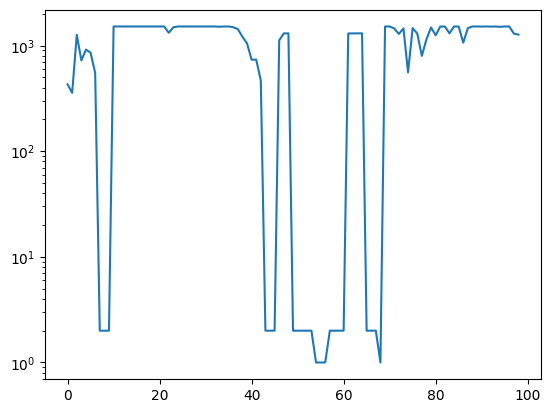

In [58]:
number_of_unique_possibilities = []

for i in range(99):
    number_of_unique_possibilities.append(len(np.unique(df[i] )))
plt.plot(number_of_unique_possibilities)
plt.yscale('log')

In [59]:
df[np.where(np.asarray(number_of_unique_possibilities)==1)[0]]

,54,55,56,68
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0
...,...,...,...,...
1512,0,0,0,0
1513,0,0,0,0
1514,0,0,0,0
1515,0,0,0,0


In [60]:
df = df.drop(columns = np.where(np.asarray(number_of_unique_possibilities)==1)[0])

In [61]:
n = len(df)
df_train = df[0:int(n*0.7)]

df_val = df[int(n*0.7):int(n*0.8)]
df_test = df[int(n*0.8):]

num_features = df.shape[1]

In [62]:
df_train_categorical = df_train[np.where(np.asarray(number_of_unique_possibilities)==2)[0]]
df_train_continuous = df_train[np.where(np.asarray(number_of_unique_possibilities)>10)[0]]

df_test_categorical = df_test[np.where(np.asarray(number_of_unique_possibilities)==2)[0]]
df_test_continuous = df_test[np.where(np.asarray(number_of_unique_possibilities)>10)[0]]

df_val_categorical = df_val[np.where(np.asarray(number_of_unique_possibilities)==2)[0]]
df_val_continuous = df_val[np.where(np.asarray(number_of_unique_possibilities)>10)[0]]

array([ 8.13724489e-01,  5.53724715e-01,  9.20793019e-03,  2.57982294e-01,
        4.45971783e-02,  5.02462531e-02,  5.97178316e-02,  9.90375495e-02,
        1.02794653e-01,  1.26338204e-01,  1.53410698e-01,  2.28728973e-01,
        2.05072542e-01,  1.97258034e-01,  1.99616856e-01,  2.01901036e-01,
       -4.57514479e-16, -2.61039578e-16])

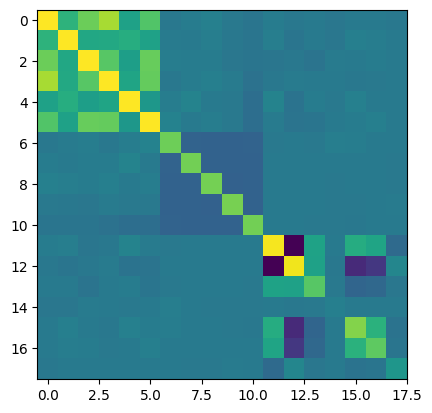

In [63]:
plt.imshow(np.cov(df_train_categorical.T))

np.linalg.eig(np.cov(df_train_categorical.T))[0]

In [64]:
train_mean = df_train_continuous.mean()
train_std = df_train_continuous.std()

df_train_continuous = (df_train_continuous - train_mean) / train_std
df_val_continuous = (df_val_continuous - train_mean) / train_std
df_test_continuous = (df_test_continuous - train_mean) / train_std

In [81]:
df_train_continuous.mean()

0     6.696916e-18
1    -2.143013e-16
2    -5.357532e-17
3    -8.371144e-18
4     1.674229e-17
          ...     
94   -6.696916e-18
95    4.018149e-17
96   -6.696916e-18
97   -1.590517e-17
98   -2.678766e-17
Length: 77, dtype: float64

In [134]:
type_of_vae = "MMD"
latent_dim = 5
top_model = False
regression_dim = 0

encoder_inputs = keras.Input(shape=(df_train_continuous.shape[1],1))

#x = tf.keras.layers.Flatten()(encoder_inputs)

x = tf.keras.layers.LSTM(512, return_sequences=True)(encoder_inputs)
#x = tf.keras.layers.BatchNormalization()(x)
#x = tf.keras.layers.AlphaDropout(rate=0.1)(x)
x = tf.keras.layers.LSTM(512)(x)
#x = tf.keras.layers.AlphaDropout(rate=0.1)(x)


if type_of_vae == "ELBO":
    z_mean = tf.keras.layers.Dense(latent_dim, name = 'z_mean')(x)
    z_log_var = tf.keras.layers.Dense(latent_dim, name = 'z_log_var')(x)
    output_latent = Sampling()([z_mean, z_log_var])
    output_dict = dict(z = output_latent, z_mean = z_mean, z_log_var = z_log_var)

else:
    z_kld = tf.keras.layers.Dense(latent_dim, name = "z_kld")(x)
    if top_model:

        x_reg_model = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer='l2')(z_kld)

        x_reg_model = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer='l2')(x_reg_model)

        z_reg_model = tf.keras.layers.Dense(regression_dim, activation='linear', name='z_reg_model', kernel_regularizer='l2')(x_reg_model)
        z_reg_model = tf.keras.layers.BatchNormalization()(z_reg_model)

        output_latent = tf.keras.layers.Concatenate()( [ z_reg_model, z_kld ] )
        output_latent = tf.keras.layers.Flatten()(output_latent)
        output_dict = dict(z=output_latent, z_reg_model = z_reg_model, z_kld = z_kld)
    else:
        output_dict = dict(z=z_kld, z_kld = z_kld)

encoder = keras.Model(inputs=encoder_inputs, outputs=output_dict, name='encoder')

decoder_inputs = keras.Input(shape = (output_dict['z_kld'].shape[1:]))

decoder_inputs = tf.expand_dims(decoder_inputs, axis=2)

x = tf.keras.layers.LSTM(512, return_sequences=True)(decoder_inputs)
#x = tf.keras.layers.BatchNormalization()(x)
#x = tf.keras.layers.AlphaDropout(rate = 0.1)(x)
x = tf.keras.layers.LSTM(512)(x)
#x = tf.keras.layers.AlphaDropout(rate = 0.1)(x)
x = tf.keras.layers.Dense(2048, activation='linear')(x)
#x = tf.keras.layers.AlphaDropout(rate = 0.1)(x)

x = tf.keras.layers.Dense(df_train_continuous.shape[1], activation = 'selu')(x)
#x = tf.keras.layers.Reshape(target_shape = [seqs.shape[1],21])(x)

decoder = keras.Model([decoder_inputs], x, name='decoder')

vae = VariationalAutoencoderWithTop(encoder, decoder, top_model, type_of_vae, weights_dict={'kl_loss':1, 'recon_loss':1, 'regression_loss':1})

if regression_dim:
    dg = DataGenerator(data = np.asarray(df_train_continuous), top_model=True, regression_target = y_train)
else:
    dg = DataGenerator(data = np.asarray(df_train_continuous), top_model = False, regression_target = None)

vae.compile(optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-3), run_eagerly = True)



In [135]:
vae.encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_46 (InputLayer)       [(None, 77, 1)]           0         
                                                                 
 lstm_35 (LSTM)              (None, 77, 512)           1052672   
                                                                 
 lstm_36 (LSTM)              (None, 512)               2099200   
                                                                 
 z_kld (Dense)               (None, 5)                 2565      
                                                                 
Total params: 3,154,437
Trainable params: 3,154,437
Non-trainable params: 0
_________________________________________________________________


In [136]:
vae.decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_48 (InputLayer)       [(None, 5, 1)]            0         
                                                                 
 lstm_37 (LSTM)              (None, 5, 512)            1052672   
                                                                 
 lstm_38 (LSTM)              (None, 512)               2099200   
                                                                 
 dense_65 (Dense)            (None, 2048)              1050624   
                                                                 
 dense_66 (Dense)            (None, 77)                157773    
                                                                 
Total params: 4,360,269
Trainable params: 4,360,269
Non-trainable params: 0
_________________________________________________________________


In [137]:
from IPython.display import clear_output

In [138]:
X_train = np.asarray(df_train_continuous)
X_test = np.asarray(df_test_continuous)







n = X_train.shape[0]
dg_train = DataGenerator(
    data = X_train[:n], 
    top_model=False,
    regression_target=None, 
    batch_size=n,
    n_steps_per_epoch=1,
    shuffle = False)

n = X_test.shape[0]
dg_test = DataGenerator(
    data = X_test[:n], 
    top_model=False,
    regression_target=None,
    batch_size=n,
    n_steps_per_epoch=1,
    shuffle=False)

train_r2 = []
test_r2 = []

for r in range(100):
    vae.fit(dg, epochs=1)
    clear_output(wait=True)
    print(r)
    retrain_x, retrain_y = dg_train[0]
    retest_x, retest_y = dg_test[0]
    
    z_train = vae.encoder(retrain_x)['z']
    z_test = vae.encoder(retest_x)['z']
    
    #rf_regressor.fit(z_train, retrain_y['Regression'])
    #print(rf_regressor.score(z_test, retest_y['Regression']))
    
    #rf_classifier = RandomForestClassifier()
    #rf_classifier.fit(z_train, retrain_y['Regression']>0)
    #print(rf_classifier.score(z_test, retest_y['Regression']>0))
    
    #print(classification_report(retest_y['Regression']>0, rf_classifier.predict(z_test)))
    
    #test_r2.append(rf_regressor.score(z_test, retest_y['Regression']))
    #plt.plot(rsquared_across_axes)
    rsquared_across_axes = []

    for i in range(X_train.shape[1]):
        rsquared_across_axes.append(
            1 - np.sum((retest_x[:,i] - vae.decoder(vae.encoder(retest_x)['z_kld'])[:,i])**2)/np.sum((retest_x[:,i] - np.mean(retest_x[:,i]))**2))
    print(sum(np.asarray(rsquared_across_axes)>0.6))
    

12


KeyboardInterrupt: 

In [124]:
    from tqdm import tqdm
    for i in tqdm(range(X_train.shape[1])):
        rsquared_across_axes.append(
            1 - np.sum((retest_x[:,i] - vae.decoder(vae.encoder(retest_x)['z_kld'])[:,i])**2)/np.sum((retest_x[:,i] - np.mean(retest_x[:,i]))**2))

100%|███████████████████████████████████████████| 77/77 [00:23<00:00,  3.22it/s]


In [125]:
    print(sum(np.asarray(rsquared_across_axes)>0.6))

57


(0.0, 1.0)

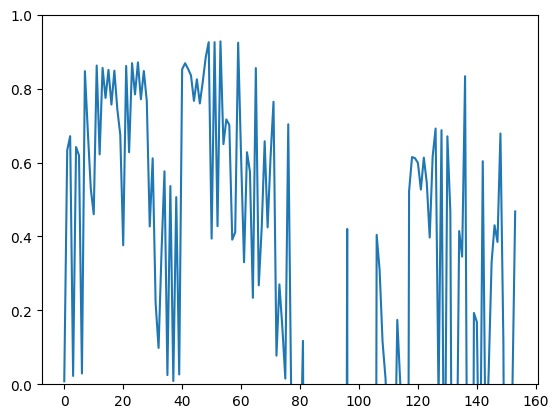

In [127]:
plt.plot(rsquared_across_axes)
plt.ylim((0,1))

(0.0, 1.0)

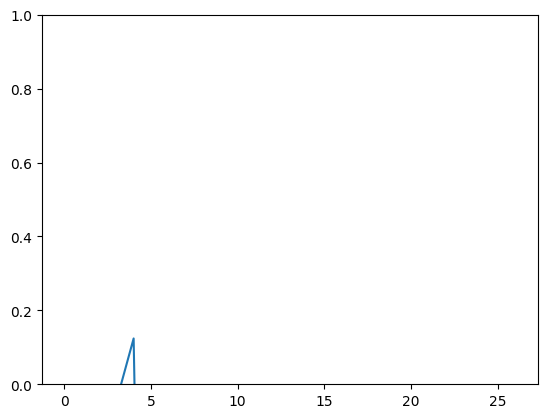

In [72]:
plt.plot(rsquared_across_axes)
plt.ylim(0,1)

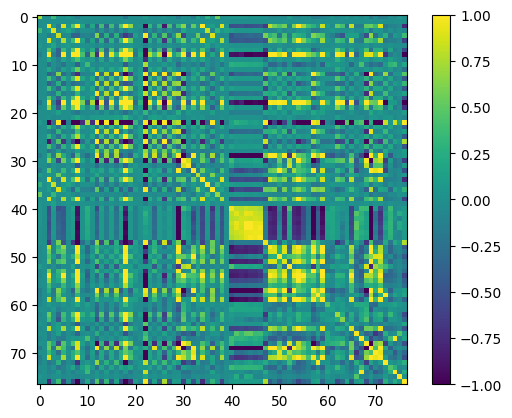

In [53]:
plt.imshow(np.cov(np.asarray(df_test_continuous).T), vmin=-1,vmax=1)
plt.colorbar()